In [1]:
import pandas as pd
import numpy as np

In [2]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import bokeh.palettes as bpal
from bokeh.models import CategoricalColorMapper
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import Legend
from bokeh.io import export_png

from bokeh.layouts import widgetbox
from bokeh.models.widgets import CheckboxGroup

output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Loading BokehJS ...

In [3]:
from glob import glob
from pprint import pprint
import dill
import json

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (cross_val_predict, cross_val_score, GridSearchCV, StratifiedShuffleSplit, 
                                     ShuffleSplit, GroupKFold)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.externals.six import StringIO  

from scipy.stats import normaltest, shapiro

from IPython.display import Image  
import pydotplus

<font color = 'purple'><font size = 5>
    A few functions used to shortcut displaying results<br>
    ================================================<br>

In [5]:
def output_CV(cv_array):     ## for use with bokeh.plotting imported
    pout = figure(plot_width = 300, plot_height = 200, y_range=(0,1)) 
    pout.circle(list(range(1, len(cv_array) +1)), cv_array, size=5)
    print('Mean CV score:  ', round(cv_array.mean(), 3))
    print('Std of CV scores:  ', round(cv_array.std(), 3))
    show(pout)

In [6]:
def give_gridsearch_results(ingridsrch_instance):
    print('Best score: ', round(ingridsrch_instance.best_score_, 3))
    print('Best params: ', ingridsrch_instance.best_params_)

In [7]:
def make_plotgrid(totalrange, ncols):
    """for feeding into bokeh gridplot, returns array of rows/columns"""
    nrows = int(np.ceil(totalrange/ncols))
    feeder = iter(range(totalrange))
    plotgrid = [[]]*nrows
    for r in range(nrows):
        thisrow = []
        for c in range(ncols):
            try:
                thisrow.append(next(feeder))
            except:
                thisrow.append(None)
        plotgrid[r] = thisrow
    return plotgrid

In [8]:
def draw_gridplot(indf, columns='first', ncols=3, total_width=900, each_height=300, incolours = ['blue','red','yellow','green','purple','orange']):
    """Grid plots by month in bokeh
    Requires:
    > indf has datetime index
    > if columns are left unspecified (should be a list of col names), then just first column is plotted
    > only takes up to 6 columns, then runs out of colours to plot unless you put more into incolours"""
    if columns == 'first':
        columns = [indf.columns[0]]
    else:
        pass
    indf['Month'] = indf.index.month
    indf['mthname'] = indf.index.month_name()
    
    each_width = int(total_width/ncols)
    
    clrcols = [(col, clr) for col, clr in zip(columns, incolours)]
    dictmonth = {}
    
    for no,mth in enumerate(indf.mthname.unique()):
        dictmonth[no] = figure(plot_width=each_width, plot_height=each_height, title=mth, x_axis_type='datetime')
        for col, clr in clrcols:
            dictmonth[no].line(indf.index[indf.Month == no+1], indf[col][indf.Month == no+1], line_width=1, color = clr)
    
    plotgrid = make_plotgrid(len(indf.mthname.unique()), ncols=ncols)
    for row in range(len(plotgrid)):
        for p in range(len(plotgrid[row])):
            plotgrid[row][p] = dictmonth[plotgrid[row][p]]
    
    the_grid = gridplot(plotgrid)
    show(the_grid)
    return the_grid

<font color = 'purple'><font size = 5>
    getting data in<br>
    ================================================<br>

In [9]:
feat_files = glob('../data/ready-for-model/*.csv')
feat_files

['../data/ready-for-model/2009-18_NEMtotaldemand.csv',
 '../data/ready-for-model/20190226_SAdf_features.csv',
 '../data/ready-for-model/20190226_TASdf_features.csv',
 '../data/ready-for-model/20190226_NSWdf_features.csv',
 '../data/ready-for-model/20190226_VICdf_features.csv',
 '../data/ready-for-model/20190226_QLDdf_features.csv']

In [10]:
fildict = {f.split('_')[1][:-2] : {'fp' : f} for f in feat_files[1:]}

fildict

{'SA': {'fp': '../data/ready-for-model/20190226_SAdf_features.csv'},
 'TAS': {'fp': '../data/ready-for-model/20190226_TASdf_features.csv'},
 'NSW': {'fp': '../data/ready-for-model/20190226_NSWdf_features.csv'},
 'VIC': {'fp': '../data/ready-for-model/20190226_VICdf_features.csv'},
 'QLD': {'fp': '../data/ready-for-model/20190226_QLDdf_features.csv'}}

In [11]:
ftarget = feat_files[0]
ftarget

'../data/ready-for-model/2009-18_NEMtotaldemand.csv'

In [12]:
dfdict = {}
for region in fildict:
    dfdict[region] = pd.read_csv(fildict[region]['fp'], index_col=0, parse_dates=[0])

In [13]:
# for region,df in dfdict.items():
#     print(region, ' : ', df.isnull().sum().max())

In [14]:
for region,df in dfdict.items():
    print(region)
    print('------'*5)
    print(df.isnull().sum())
    print("======"*10)

SA
------------------------------
Date                                0
Hour_of_day                         0
Year                                0
shoulder                            0
summer                              0
winter                              0
workdaySA                           1
MOUNT-GAMBIER-AERO_MaxT_26021     288
ADELAIDE-AIRPORT_MinT_23034         0
MURRAY-BRIDGE_MinT_24584          672
PORT-AUGUSTA_MaxT_18201          2160
MOUNT-GAMBIER-AERO_MinT_26021     192
ADELAIDE-AIRPORT_MaxT_23034         0
MURRAY-BRIDGE_MaxT_24584          720
PORT-AUGUSTA_MinT_18201          2640
dtype: int64
TAS
------------------------------
Date                       0
Hour_of_day                0
Year                       0
shoulder                   0
summer                     0
winter                     0
workdayTAS                 1
HOBART_MinT_94029         48
LAUNCESTON_MaxT_91237    432
HOBART_MaxT_94029        192
LAUNCESTON_MinT_91237    240
dtype: int64
NSW
------------

In [15]:
dftarget = pd.read_csv(ftarget, index_col=0, parse_dates=[0])
dftarget.head(3)

NSW1     QLD1      SA1    TAS1     VIC1  NEMtotal
SETTLEMENTDATE                                                           
2009-01-01 00:30:00  7535.00  5611.54  1310.89  909.71  4799.87  20167.01
2009-01-01 01:00:00  7229.24  5457.34  1272.69  896.63  4646.21  19502.11
2009-01-01 01:30:00  6857.62  5294.12  1178.87  897.52  4950.16  19178.29

In [16]:
for region, df in dfdict.items():
    y = dftarget[[region+'1']]
    dfdict[region] = pd.merge(df, y, how='inner', left_index=True, right_index=True).dropna()
    ## merge target with features to drop same rows where missing data exists, end up with 
    ## correctly corresponding indexes on features and target

<font color = 'purple'><font size = 4>
    Creating training and holdout test sets - pre-2018 and 2018 data respectively<br>
    =====================================================<br>

In [17]:
yraw = {}
dfYdict = {}
for region, df in dfdict.items():
    yraw[region] = df[region+'1']  ## holding onto unrounded data separately, just in case
    dfYdict[region] = np.ceil(df[region+'1']/5.0)*5.0
    # am going to round up targets to nearest multiple of 5 to reduce regression complexity
    dfdict[region] = df.drop(columns=['Date', region+'1'])

In [18]:
# print(len(Yvic.VIC1.unique()))
# print(len(Yvic.rVIC.unique()))
# print(f'reduced by factor of: {round(len(Yvic.VIC1.unique())/len(Yvic.rVIC.unique()))} !')

In [ ]:
Ytrains = {}
Ytests = {}

for region, yt in dfYdict.items():
    Ytrains[region] = yt[yt.index.year != 2018].copy()
    Ytests[region] = yt[yt.index.year == 2018].copy()

In [ ]:
Xtrains = {}
Xtests = {}

for region, df in dfdict.items():
    Xtrains[region] = df[df.Year != 2018].astype(float).copy() # to avoid StandardScaler warnings about 
    Xtests[region] = df[df.Year == 2018].astype(float).copy()  # conversions to float filling up the page...

In [ ]:
Xtests['SA'].head(3)

Hour_of_day    Year  shoulder  summer  winter  workdaySA  \
SETTLEMENTDATE                                                                  
2018-01-01 00:00:00          0.0  2018.0       0.0     1.0     0.0        0.0   
2018-01-01 00:30:00          0.5  2018.0       0.0     1.0     0.0        0.0   
2018-01-01 01:00:00          1.0  2018.0       0.0     1.0     0.0        0.0   

                     MOUNT-GAMBIER-AERO_MaxT_26021  \
SETTLEMENTDATE                                       
2018-01-01 00:00:00                           23.5   
2018-01-01 00:30:00                           23.5   
2018-01-01 01:00:00                           23.5   

                     ADELAIDE-AIRPORT_MinT_23034  MURRAY-BRIDGE_MinT_24584  \
SETTLEMENTDATE                                                               
2018-01-01 00:00:00                         16.6                      16.0   
2018-01-01 00:30:00                         16.6                      16.0   
2018-01-01 01:00:00                         16.6                      16.0   

                     PORT-AUGUSTA_MaxT_18201  MOUNT-GAMBIER-AERO_MinT_26021  \
SETTLEMENTDATE                                                                
2018-01-01 00:00:00                     28.2                           14.4   
2018-01-01 00:30:00                     28.2                           14.4   
2018-01-01 01:00:00                     28.2                           14.4   

                     ADELAIDE-AIRPORT_MaxT_23034  MURRAY-BRIDGE_MaxT_24584  \
SETTLEMENTDATE                                                               
2018-01-01 00:00:00                         23.0                      27.2   
2018-01-01 00:30:00                         23.0                      27.2   
2018-01-01 01:00:00                         23.0                      27.2   

                     PORT-AUGUSTA_MinT_18201  
SETTLEMENTDATE                                
2018-01-01 00:00:00                     17.6  
2018-01-01 00:30:00                     17.6  
2018-01-01 01:00:00                     17.6

<font color = 'purple'><font size = 5>
    Random Forest<br>
    =====================================================<br>

In [ ]:
entmoot = {k: RandomForestRegressor(n_estimators=60, min_samples_leaf=5, max_depth=30) for k in dfdict.keys()}
# Am creating a dictionary with a different RF model for each NEM region

In [ ]:
%%time
for region in entmoot.keys():
    entmoot[region].fit(Xtrains[region], Ytrains[region])
    print(f"{region} fitted")

SA fitted
TAS fitted
NSW fitted


In [ ]:
entpredicts = pd.DataFrame()

In [ ]:
%%time
for region in entmoot.keys():
    df = pd.DataFrame(index=Xtests[region].index, data=entmoot[region].predict(Xtests[region]), columns=[region])
    entpredicts = pd.merge(entpredicts, df, how='outer', left_index=True, right_index=True)

In [ ]:
entpredicts.head(3)

In [ ]:
entpredicts.isnull().any(axis=1).sum() / len(entpredicts)

In [ ]:
# entsays = pd.DataFrame(index=dftarget.index[dftarget.index.year == 2018])

# for region in entpredicts.columns:
#     df = pd.merge(dftarget[[region+'1']], entpredicts[[region]].dropna(), how='inner', left_index=True, right_index=True)
#     entsays = pd.merge(entsays, df, how='outer', left_index=True, right_index=True)

# df = pd.DataFrame(entpredicts.dropna().sum(axis=1), columns=['NEMpred'])
# df = pd.merge(dftarget[['NEMtotal']], df, how='inner', left_index=True, right_index=True)
# entsays = pd.merge(entsays, df, how='outer', left_index=True, right_index=True)

# entsays.rename(columns={c:c+'pred' for c in entsays.columns if '1' not in c and len(c) < 4}, inplace=True)
# entsays.rename(columns={'NEMtotal':'NEM1'}, inplace=True)
# entsays['Ntot_err'] = entsays.NEM1 - entsays.NEMpred
# entsays.head()
# # creates merged results dataframe with only NaN where is missing from each particular region
# # but NEM totals only where we have a value for every region

In [ ]:
# entsays['pos_err'] = entsays.Ntot_err.apply(lambda x: x if x >= 0 else np.NaN)
# entsays['neg_err'] = entsays.Ntot_err.apply(lambda x: x if x < 0 else np.NaN)
# entsays.head(2)

In [ ]:
## entsays.to_csv("2018-test-actual-v-predicted.csv")
entsays = pd.read_csv('2018-test-actual-v-predicted.csv', index_col=0, parse_dates=[0])
entsays.head(2)

In [ ]:
ent_scores = {k:v for k,v in zip([d.split('1')[0][:3] for d in dftarget.columns], [None]*6)}
ent_scores

In [ ]:
for region in ent_scores.keys():
    ent_scores[region] = round(r2_score(entsays[region+'1'].dropna(), entsays[region+'pred'].dropna()),2)
ent_scores

<font color = 'purple'><font size = 5>
    Cross-validating results<br>
    =====================================================<br>

In [ ]:
cvresults = {k:v for k,v in zip([d.split('1')[0][:3] for d in dftarget.columns], [None]*6)}
cvresults

In [ ]:
# %%time
# for region, rfmodel in entmoot.items():
#     gkf = GroupKFold(n_splits=9)
#     cvgkf = gkf.split(Xtrains[region], groups=Xtrains[region]['Year'])
#     cvresults[region] = cross_val_score(estimator=rfmodel, X=Xtrains[region], y=Ytrains[region], cv=cvgkf, n_jobs=-1)
#     print(region)

In [ ]:
# with open("CVresults-allNEM-RF.pickle", 'wb') as outfile:
#     dill.dump(cvresults, outfile)

In [ ]:
with open("*/pickles/CVresults-allNEM-RF.pickle", 'rb') as infile:
    cvresults = dill.load(infile)
cvresults

In [ ]:
cvresults

In [ ]:
cvdf = pd.DataFrame(cvresults)
# cvdf.drop(columns='NEM', inplace=True)
cvdf

<font color = 'purple'><font size = 5>
    Charting results<br>
    =====================================================<br>

In [ ]:
ent_cmap = {'SA': '#1f77b4',
 'TAS': '#ff7f0e',
 'NSW': '#2ca02c',
 'VIC': '#d62728',
 'QLD': '#9467bd',
           'NEM' : '#333333'}

In [ ]:
knn_scores = {'NSW': 0.81, 'QLD': 0.83, 'SA': 0.61, 'TAS': 0.61, 'VIC': 0.76, 'NEM': 0.86}   
# # just c-p'd from other notebook :)

In [ ]:
kcmap = {k:v for k,v in zip(ent_cmap.keys(), bpal.Category20_10[1::2])}
kcmap['NEM'] = '#666666'
kcmap

In [ ]:
dfresults = pd.DataFrame([ent_scores,knn_scores, ent_cmap, kcmap], index=['RF','KNN','ec','kc'])
dfresults = dfresults[cvdf.columns]
dfresults

In [ ]:
mcolors = [ent_cmap[region] for region in dfresults.columns]
mcolors

In [ ]:
fig1, ax1 = plt.subplots(figsize = (18,10))

# cross-validation scores as boxplots
sns.boxplot(data=cvdf, ax=ax1, width=0.35)

box_cols = ax1.artists
for region,box in zip(cvdf.columns, box_cols):
    box.set_facecolor(kcmap[region])
    
# hold-out test set scores as circle markers
index = np.arange(6)
bar_width = 0.5

ents = ax1.scatter(x=index, y=dfresults.loc['RF',:], s=200, c=mcolors, linewidths=2, edgecolors='black')

for x,y in zip(index, dfresults.loc['RF',:]):
    ax1.text(x=x+0.19, y=y-.007, s=y, fontsize=15)

## chart formatting
ax1.set_ylim(0,1)
ax1.set_xticklabels(dfresults.columns, fontsize=30)
plt.tick_params('y', labelsize=20)

## labels
plt.suptitle('Accuracy Scores', fontsize=36)
ax1.text(x=0.5, y=0.3, fontsize=15 , s='Boxplot = cross-validation scores on training dataset (2009-2017)')
ax1.text(x=0.5, y=0.2, fontsize=15 , s='Marker/label = accuracy score on hold-out test set (2018)')

plt.savefig('../charts_out/cross-val-RF-NEMscores.png')

plt.show()

In [ ]:
actcolour = '#e4bd0b'  # colour to use for 'actual' data on below graphs, can change for better contrast

<font color = 'purple'><font size = 7>
    Visualising Actual vs Predicted <br><br>
    2018 Holdout test set<br>
    ==============================<br>

<font color = #333333><font size = 6><br><br><br>
    NEM-wide total<br>
    =====================================================<br>

In [239]:
pnem = figure(x_axis_type='datetime', plot_width= 900, plot_height=550, title='Interactive')
pnem.line(entsays.index, entsays.NEM1, line_width=1, color=actcolour, legend='Actual')
pnem.line(entsays.index, entsays.NEMpred, line_width=1, color='black', legend='Predicted')
pnem.legend.location = 'top_left'
show(pnem)

<font color = #2ca02c><font size = 6>
    New South Wales<br>
    =====================================================<br>

In [240]:
pnsw = figure(x_axis_type='datetime', plot_width= 900, plot_height=550, title='Interactive')
pnsw.line(entsays.index, entsays.NSW1, line_width=1, color=actcolour, legend='Actual')
pnsw.line(entsays.index, entsays.NSWpred, line_width=1, color=ent_cmap['NSW'], legend='Predicted')
pnsw.legend.location = 'top_left'
show(pnsw)

<font color = #9467bd><font size = 5>
    Queensland<br>
    =====================================================<br>

In [241]:
pq = figure(x_axis_type='datetime', plot_width= 900, plot_height=550, title='Interactive')

pq.line(entsays.index, entsays.QLD1, line_width=1, color=actcolour, legend='Actual')
pq.line(entsays.index, entsays.QLDpred, line_width=1, color=ent_cmap['QLD'], legend='Predicted')
pq.legend.location = 'top_left'

show(pq)

<font color = #d62728><font size = 5>
    Victoria<br>
    =====================================================<br>

In [242]:
pv = figure(x_axis_type='datetime', plot_width= 900, plot_height=550, title='Interactive')

pv.line(entsays.index, entsays.VIC1, line_width=1, color=actcolour, legend='Actual')
pv.line(entsays.index, entsays.VICpred, line_width=1, color=ent_cmap['VIC'], legend='Predicted')
pv.legend.location = 'top_left'

show(pv)

<font color = #1f77b4><font size = 5>
    South Australia<br>
    =====================================================<br>

In [243]:
psa = figure(x_axis_type='datetime', plot_width= 900, plot_height=550, title='Interactive')

psa.line(entsays.index, entsays.SA1, line_width=1, color=actcolour, legend='Actual')
psa.line(entsays.index, entsays.SApred, line_width=1, color=ent_cmap['SA'], legend='Predicted')
psa.legend.location = 'top_left'

show(psa)

<font color = #ff7f0e><font size = 5>
    Tasmania<br>
    =====================================================<br>

In [245]:
pt = figure(x_axis_type='datetime', plot_width= 900, plot_height=550, title='Interactive')

pt.line(entsays.index, entsays.TAS1, line_width=1, color=actcolour, legend='Actual')
pt.line(entsays.index, entsays.TASpred, line_width=1, color=ent_cmap['TAS'], legend='Predicted')
pt.legend.location = 'top_left'

show(pt)

In [63]:
draw_gridplot(entsays, columns=['NEM1', 'NEMpred'])

Column(id='2078', ...)

<font color = 'purple'><font size = 3>
    Zoom in on particular problem area<br>

In [62]:
first = figure(x_axis_type='datetime', plot_width= 700, plot_height=350, title='November 2018 - NEM totals')
# first.title.text_font_size = 'large'
first.line(entsays.index[entsays.index.month==11], entsays.NEM1[entsays.index.month==11], line_width=1, 
           color='blue', legend='Actual')
first.line(entsays.index[entsays.index.month==11], entsays.NEMpred[entsays.index.month==11], line_width=1, 
           color='red', legend='Predicted')
first.legend.location = 'top_left'

show(first)

In [172]:
# fig1, ax1 = plt.subplots(figsize=(15,10))

# index = np.arange(6)
# bar_width = 0.5

# ents = ax1.bar(x=index, height=dfresults.loc['RF',:], width=bar_width, color=dfresults.loc['ec',:])
# # knns = ax1.bar(x=index+bar_width, height=dfresults.loc['KNN',:], width=bar_width, color=dfresults.loc['kc',:])

# exlocs = [ent.get_x() for ent in ents]
# kxlocs = [ent.get_x()+bar_width for ent in ents]

# for x,y in zip(exlocs, dfresults.loc['RF',:]):
#     ax1.text(x=x+0.05, y=y+0.02, s=y, fontsize=15)
    
# # for x,y in zip(kxlocs, dfresults.loc['KNN',:]):
# #     ax1.text(x=x+0.05, y=y+0.02, s=y, fontsize=15)

# ax1.set_ylim(0,1)
# ax1.set_xticks(index)# + bar_width / 2)
# ax1.set_xticklabels(dfresults.columns, fontsize=30)
# plt.tick_params('y', labelsize=15)
# # plt.suptitle('R2 score for Random Forest (bold) and KNN (pale)', fontsize=36)
# plt.suptitle('Accuracy score', fontsize=36)

# plt.savefig('../charts_out/final-RFonly-r2-scores-barplot.png')
# plt.show()

In [61]:
# for no,mth in enumerate(indf.mthname.unique()):
#     dictmonth[no] = figure(plot_width=each_width, plot_height=each_height, title=mth, x_axis_type='datetime')
#     for col, clr in clrcols:
#         dictmonth[no].line(indf.index[indf.Month == no+1], indf[col][indf.Month == no+1], line_width=1, color = clr)


In [ ]:
posneg = draw_gridplot(entsays, ncols=4, each_height=200, columns=['pos_err','neg_err'], incolours=['green','maroon'])
export_png(posneg, 'RF-pos-neg-error-NEMtotal.png')

In [36]:
with open('./pickles/knn-results-dataframe.pickle', 'rb') as infile:
    kbresults = dill.load(infile)

In [76]:
comparison_norm = np.random.normal(loc=0, scale=entsays.Ntot_err.std(), size=len(entsays.Ntot_err))
comparison_norm

array([-565.34212172, -380.70018624,  693.13017235, ...,  252.09253824,
       -538.72131205,  185.8159717 ])

/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


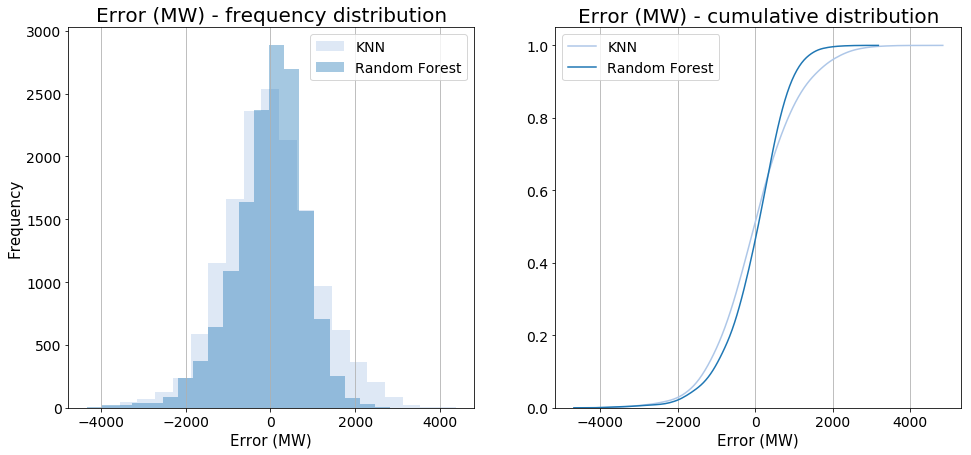

In [116]:
erfig, erax = plt.subplots(ncols=2, figsize = (16,7))

erhist = erax[0]
ercdf = erax[1]

## frequency distribution histogram
sns.distplot(kbresults.Ntot_err, bins=20, kde=False, ax=erhist, color='#aec7e8', label='KNN')
sns.distplot(entsays.Ntot_err, bins=20, kde=False, ax=erhist, color='#1f77b4', label='Random Forest')

erhist.grid(b=True, which='major', axis='x')
erhist.set_xlabel('Error (MW)', fontsize=15)
erhist.set_ylabel('Frequency', fontsize=15)
erhist.tick_params('both', labelsize=14)
erhist.set_title('Error (MW) - frequency distribution', fontsize=20)
erhist.legend(fontsize=14)

## cumulative distribution kdeplot
sns.kdeplot(kbresults.Ntot_err.dropna(), ax=ercdf, color='#aec7e8', cumulative=True, label='KNN')
sns.kdeplot(entsays.Ntot_err.dropna(), ax=ercdf, color='#1f77b4', cumulative=True, label='Random Forest')

ercdf.grid(b=True, which='major', axis='x')
ercdf.set_xlabel('Error (MW)', fontsize=15)
ercdf.legend(fontsize=14)
ercdf.tick_params('both', labelsize=14)
ercdf.set_title('Error (MW) - cumulative distribution', fontsize=20)

plt.savefig('../charts_out/sortederror-RF-KNN-NEMtotal.png')
plt.show()

In [64]:
print ((entsays.Ntot_err.abs() < 2000).sum() / len(entsays))
print ((entsays.Ntot_err.abs() < 1000).sum() / len(entsays))

0.8233447488584474
0.675513698630137


In [65]:
entsays.Ntot_err.std()

837.6662772378376

In [65]:
# draw_gridplot(entsays[abs(entsays.Ntot_err) > 2000], ncols=4, each_height=200, columns=['pos_err','neg_err'], incolours=['green','maroon'])

In [68]:
normaltest(entsays.Ntot_err.dropna())

NormaltestResult(statistic=1620.3150298994603, pvalue=0.0)

In [72]:
shapiro(entsays.Ntot_err.dropna())

/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9709400534629822, 0.0)

In [74]:
import scipy.stats as sstats

In [ ]:
sstats.norm()